In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Image Captioning with LSTMs
In the previous exercise, you implemented a vanilla RNN and applied it to image captioning. In this notebook, you will implement the LSTM update rule and use it for image captioning.

In [1]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
As in the previous notebook, we will use the COCO dataset for captioning.

In [532]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  C:\Users\alexe\Desktop\stanford_CV\assignment3_git\cs231n\datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
A common variant on the vanilla RNN is the Long-Short Term Memory (LSTM) RNN. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$ and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: Step Forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-8` or less.

In [27]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


# LSTM: Step Backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-7` or less.

In [85]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.833434184302307e-10
dh error:  3.4168728051126624e-10
dc error:  1.5221747946070454e-10
dWx error:  1.6933647290937225e-09
dWh error:  2.7311389754207126e-08
db error:  1.7349350966431763e-10


# LSTM: Forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error on the order of `e-7` or less.

In [88]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537442272635e-08


# LSTM: Backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-8` or less. (For `dWh`, it's fine if your error is on the order of `e-6` or less).

In [93]:
from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.148080829944732e-10
dh0 error:  2.3824794284312267e-08
dWx error:  8.000902497865783e-10
dWh error:  6.064215130763785e-07
db error:  6.280899116725197e-10


#### Vanishing gradient

#### RNN

In [2]:
np.random.seed(1)

N, D, T, H = 1, 3, 3, 4

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

dh = dout

In [ ]:
# to understand vanishing gradient, as we described in the blog https://medium.com/@alexml0123/backpropagation-and-vanishing-gradient-problem-in-rnn-clearly-explained-efce8824971b,
# we need to compute the contribution to individual losses at each timestep. The loop we used to compute the gradient in the tutorial doesn't directly provide us with this information,
# thus we need to modify the backpropagation code to compute those components

In [3]:
# let's first compute manually all the components of Loss3 with respect to Wx. 
# There will be 3 components because there are 3 timesteps up to and including Loss3

t = 2
(xt, _, _, next_h, prev_h) = cache[t]
dLdWx_comp1 = xt.T.dot( dh[:, t, :]  * (1 - next_h**2))

xt_1 = cache[t-1][0]
next_h_1 = cache[t-1][-2]
dLdWx_comp2 = xt_1.T.dot((dh[:, t, :]  * (1 - next_h**2)).dot(Wh.T) * (1 - next_h_1**2))

xt_2 = cache[t-2][0]
next_h_2 = cache[t-2][-2]
dLdWx_comp3 = xt_2.T.dot(((dh[:, t, :] * (1 - next_h**2)).dot(Wh.T) * (1 - next_h_1**2)).dot(Wh.T) * (1 - next_h_2**2))

In [4]:
dLdWx_comp1 + dLdWx_comp2 + dLdWx_comp3

array([[-0.11265219, -0.32975674,  1.04298019,  0.6696128 ],
       [ 0.04854351,  0.13945587, -0.46157534, -0.29297507],
       [-0.01994111, -0.04071621,  0.22437918,  0.12942807]])

In [863]:
dLdWx_comp1

array([[-0.12964021, -0.36447594,  1.01880983,  0.68256384],
       [ 0.05655798,  0.15900947, -0.44447492, -0.2977813 ],
       [-0.02370473, -0.06664448,  0.18628953,  0.1248069 ]])

In [680]:
# # to evaluate the gradient of L3 with respect to x3
# fWx = lambda Wx: rnn_step_forward(x[:, -1, :], next_h_1, Wx, Wh, b)[0]
# eval_numerical_gradient_array(fWx, Wx, dout[:, 2, :])

array([[-0.12964824, -0.36447594,  1.01880983,  0.68256384],
       [ 0.05656148,  0.15900947, -0.44447492, -0.2977813 ],
       [-0.0237062 , -0.06664448,  0.18628953,  0.1248069 ]])

In [862]:
# to evaluate the gradient of L3 with respect to x3
fWx = lambda Wx: rnn_forward(x[:, -1:, :], next_h_1, Wx, Wh, b)[0][:, -1, :]
eval_numerical_gradient_array(fWx, Wx, dout[:, 2, :])

array([[-0.12964021, -0.36447594,  1.01880983,  0.68256384],
       [ 0.05655798,  0.15900947, -0.44447492, -0.2977813 ],
       [-0.02370473, -0.06664448,  0.18628953,  0.1248069 ]])

In [854]:
# How L3 (or more precisely, last hidden state (we select [:, -1, :]) as
# we compute h instead of losses here assuming the upstream gradient is known - dout)
# changes if we change Wx. However, we cannot get individual effect in this way, only the entire
# sum, however we can do it as difference. See below
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0][:, -1, :]
L3_tot = eval_numerical_gradient_array(fWx, Wx, dout[:, -1, :])
L3_tot

array([[-0.11265219, -0.32975674,  1.04298019,  0.6696128 ],
       [ 0.04854351,  0.13945587, -0.46157534, -0.29297507],
       [-0.01994111, -0.04071621,  0.22437918,  0.12942807]])

In [672]:
dLdWx_comp2 + dLdWx_comp1

array([[-0.12588038, -0.3494092 ,  1.03741126,  0.68272983],
       [ 0.05352547,  0.14685732, -0.45947799, -0.29791517],
       [-0.01563983, -0.03432602,  0.22618997,  0.12516294]])

In [671]:
# get the last two sums, i.e., effect of the change in Wx starting from x2 (x2 and x3)
# we then can subtract this effect from total L3 effect to get effect for x1 only
fWx = lambda Wx: rnn_forward(x[:, 1:, :], next_h_2, Wx, Wh, b)[0][:, -1, :]
eval_numerical_gradient_array(fWx, Wx, dout[:, -1, :])

array([[-0.12588861, -0.3494091 ,  1.03741094,  0.68272982],
       [ 0.05352913,  0.14685725, -0.45947774, -0.29791518],
       [-0.0156417 , -0.03432582,  0.22618932,  0.125163  ]])

In [683]:
# get the last two sums, i.e., effect of the change in Wx starting from x2 (x2 and x3)
# we then can subtract this effect from total L3 effect to get effect for x1 only
fWx = lambda Wx: rnn_forward(x[:, 1:, :], next_h_2, Wx, Wh, b)[0][:, -1, :]
L3_tot - eval_numerical_gradient_array(fWx, Wx, dout[:, -1, :])

array([[ 0.01322724,  0.01965264,  0.00556924, -0.01311809],
       [-0.00498157, -0.0074015 , -0.00209763,  0.00494056],
       [-0.00430122, -0.0063904 , -0.00180996,  0.00426494]])

In [674]:
dLdWx_comp3

array([[ 0.0132282 ,  0.01965245,  0.00556892, -0.01311703],
       [-0.00498197, -0.00740145, -0.00209735,  0.0049401 ],
       [-0.00430128, -0.00639019, -0.00181079,  0.00426513]])

In [861]:
# get the middle component, we simply subtract from sum of two components (dLdWx_comp2 + dLdWx_comp1) the first component
fWx1 = lambda Wx: rnn_forward(x[:, -1:, :], next_h_1, Wx, Wh, b)[0][:, -1, :] # first component
fWx3 = lambda Wx: rnn_forward(x[:, 1:, :], next_h_2, Wx, Wh, b)[0][:, -1, :] # sum of first two components
# L3_tot - eval_numerical_gradient_array(fWx1, Wx, dout[:, -1, :]) - (L3_tot - eval_numerical_gradient_array(fWx3, Wx, dout[:, -1, :]))
# same as
eval_numerical_gradient_array(fWx3, Wx, dout[:, -1, :]) - eval_numerical_gradient_array(fWx1, Wx, dout[:, -1, :])

array([[ 0.00375982,  0.01506674,  0.01860143,  0.00016598],
       [-0.0030325 , -0.01215215, -0.01500307, -0.00013388],
       [ 0.0080649 ,  0.03231846,  0.03990044,  0.00035604]])

In [856]:
dLdWx_comp2

array([[ 0.00375982,  0.01506674,  0.01860143,  0.00016598],
       [-0.0030325 , -0.01215215, -0.01500307, -0.00013388],
       [ 0.0080649 ,  0.03231846,  0.03990044,  0.00035604]])

In [472]:
# this is just for comparison from previous implementation

t = 2
# (xt, prev_h, _, _, _, next_h) = cache[t]
(xt, _, _, next_h, prev_h) = cache[t]
dJ3dWxh =            xt.T.dot( dh[:, t, :]  * (1 - cache[t][-2]**2)) + \
          cache[t-1][0].T.dot((dh[:, t, :]  * (1 - cache[t][-2]**2)).dot(Wh.T) * (1 - cache[t-1][-2]**2)) + \
          cache[t-2][0].T.dot(((dh[:, t, :] * (1 - cache[t][-2]**2)).dot(Wh.T) * (1 - cache[t-1][-2]**2)).dot(Wh.T) * (1 - cache[t-2][-2]**2))
display(dJ3dWxh)
# t = 1
# (xt, _, _, next_h, prev_h)  = cache[t]
# dJ2dWxh =            xt.T.dot( dh[:, t, :] * (1 - cache[t][-2]**2)) + \
#           cache[t-1][0].T.dot((dh[:, t, :] * (1 - cache[t][-2]**2)).dot(Wh.T) * (1 - cache[t-1][-2]**2))

# t = 0
# (xt, _, _, next_h, prev_h)  = cache[t]
# dJ1dWxh =            xt.T.dot( dh[:, t, :] * (1 - cache[t][-2]**2)) 

array([[-0.11265219, -0.32975674,  1.04298019,  0.6696128 ],
       [ 0.04854351,  0.13945587, -0.46157534, -0.29297507],
       [-0.01994111, -0.04071621,  0.22437918,  0.12942807]])

In [5]:
# Now let's do it automatically for all timesteps and all losees 

# in the losses dict, first key represent the timestep of the loss, while keys within each loss
# represent the gradient for each component
losses = {i : {x_comp : 0 for x_comp in range(i)} for i in range(T)}
dh = dout
for i in range(T-1, -1, -1):
    mid =  dh[:, i, :]  * (1 - cache[i][-2]**2)
    for j in range(i, -1, -1):
        xj = cache[j][0]
        next_h_j = cache[j-1][-2]
        losses[i][j] = xj.T.dot(mid)
        mid = mid.dot(Wh.T) * (1 - next_h_j**2)

In [474]:
dLdWx_comp1, dLdWx_comp2, dLdWx_comp3

(array([[-0.12964021, -0.36447594,  1.01880983,  0.68256384],
        [ 0.05655798,  0.15900947, -0.44447492, -0.2977813 ],
        [-0.02370473, -0.06664448,  0.18628953,  0.1248069 ]]),
 array([[ 0.00375982,  0.01506674,  0.01860143,  0.00016598],
        [-0.0030325 , -0.01215215, -0.01500307, -0.00013388],
        [ 0.0080649 ,  0.03231846,  0.03990044,  0.00035604]]),
 array([[ 0.0132282 ,  0.01965245,  0.00556892, -0.01311703],
        [-0.00498197, -0.00740145, -0.00209735,  0.0049401 ],
        [-0.00430128, -0.00639019, -0.00181079,  0.00426513]]))

In [34]:
display(losses[2])

{0: array([[ 0.0132282 ,  0.01965245,  0.00556892, -0.01311703],
        [-0.00498197, -0.00740145, -0.00209735,  0.0049401 ],
        [-0.00430128, -0.00639019, -0.00181079,  0.00426513]]),
 1: array([[ 0.00375982,  0.01506674,  0.01860143,  0.00016598],
        [-0.0030325 , -0.01215215, -0.01500307, -0.00013388],
        [ 0.0080649 ,  0.03231846,  0.03990044,  0.00035604]]),
 2: array([[-0.12964021, -0.36447594,  1.01880983,  0.68256384],
        [ 0.05655798,  0.15900947, -0.44447492, -0.2977813 ],
        [-0.02370473, -0.06664448,  0.18628953,  0.1248069 ]])}

In [476]:
dJ3dWxh

array([[-0.11265219, -0.32975674,  1.04298019,  0.6696128 ],
       [ 0.04854351,  0.13945587, -0.46157534, -0.29297507],
       [-0.01994111, -0.04071621,  0.22437918,  0.12942807]])

In [477]:
np.sum([losses[2][e] for e in losses[2]], 0)

array([[-0.11265219, -0.32975674,  1.04298019,  0.6696128 ],
       [ 0.04854351,  0.13945587, -0.46157534, -0.29297507],
       [-0.01994111, -0.04071621,  0.22437918,  0.12942807]])

In [478]:
# we can also see that if we sum all the losses across all components we get total gradient for dWx
np.allclose(dWx, np.sum([losses[l][e] for l in losses for e in losses[l]], 0))

True

Now looking at the components you should see that component_3, that corresponds to the loss update due to the x3 of this formula
\
\
$$\frac{\partial L_3}{\partial W_{xh}} = dout_3\times(\frac{\partial h_3}{\partial z_{3}}
\frac{\partial z_3}{\partial W_{xh}} +\frac{\partial h_3}{\partial z_{3}}
\frac{\partial z_3}{\partial h_2}\frac{\partial h_2}{\partial z_2} \frac{\partial z_2}{\partial W_{xh}} +\frac{\partial h_3}{\partial z_{3}}\frac{\partial z_3}{\partial h_2}\frac{\partial h_2}{\partial z_2} \frac{\partial z_2}{\partial h_1}\frac{\partial h_1}{\partial z_1}\frac{\partial z_1}{\partial W_{xh}})$$

so this part 
$$\frac{\partial h_3}{\partial z_{3}}\frac{\partial z_3}{\partial h_2}\frac{\partial h_2}{\partial z_2} \frac{\partial z_2}{\partial h_1}\frac{\partial h_1}{\partial z_1}\frac{\partial z_1}{\partial W_{xh}}$$
\
which basically says how much the input in x3 contributes to the L3, we see that this component corresponds to the smallest gradient thus there is not much info in L3 about this part and this is the vanishing gradient problem

In [504]:
print(dLdWx_comp1, "\n\n", dLdWx_comp2, "\n\n", dLdWx_comp3)
print("\n")
print("Let's see the magnitudes of them")
print("\n comp 1:", np.linalg.norm(dLdWx_comp1), "\n comp 2:", np.linalg.norm(dLdWx_comp2),"\n comp 3:", np.linalg.norm(dLdWx_comp3))

[[-0.12964021 -0.36447594  1.01880983  0.68256384]
 [ 0.05655798  0.15900947 -0.44447492 -0.2977813 ]
 [-0.02370473 -0.06664448  0.18628953  0.1248069 ]] 

 [[ 0.00375982  0.01506674  0.01860143  0.00016598]
 [-0.0030325  -0.01215215 -0.01500307 -0.00013388]
 [ 0.0080649   0.03231846  0.03990044  0.00035604]] 

 [[ 0.0132282   0.01965245  0.00556892 -0.01311703]
 [-0.00498197 -0.00740145 -0.00209735  0.0049401 ]
 [-0.00430128 -0.00639019 -0.00181079  0.00426513]]


Let's see the magnitudes of them

 comp 1: 1.4225029296044476 
 comp 2: 0.06058764108583098 
 comp 3: 0.03087853793900866


In [39]:
display([losses[2][e] for e in losses[2]])
print("\n")
print("Let's see the magnitudes of them:")
print("\n")
display([f"component {e+1} : {np.linalg.norm(losses[2][e])}" for e in losses[2]])

[array([[ 0.0132282 ,  0.01965245,  0.00556892, -0.01311703],
        [-0.00498197, -0.00740145, -0.00209735,  0.0049401 ],
        [-0.00430128, -0.00639019, -0.00181079,  0.00426513]]),
 array([[ 0.00375982,  0.01506674,  0.01860143,  0.00016598],
        [-0.0030325 , -0.01215215, -0.01500307, -0.00013388],
        [ 0.0080649 ,  0.03231846,  0.03990044,  0.00035604]]),
 array([[-0.12964021, -0.36447594,  1.01880983,  0.68256384],
        [ 0.05655798,  0.15900947, -0.44447492, -0.2977813 ],
        [-0.02370473, -0.06664448,  0.18628953,  0.1248069 ]])]



Let's see the magnitudes of them:




['component 1 : 0.03087853793900866',
 'component 2 : 0.06058764108583098',
 'component 3 : 1.4225029296044476']

In [38]:
losses[2]

{0: array([[ 0.0132282 ,  0.01965245,  0.00556892, -0.01311703],
        [-0.00498197, -0.00740145, -0.00209735,  0.0049401 ],
        [-0.00430128, -0.00639019, -0.00181079,  0.00426513]]),
 1: array([[ 0.00375982,  0.01506674,  0.01860143,  0.00016598],
        [-0.0030325 , -0.01215215, -0.01500307, -0.00013388],
        [ 0.0080649 ,  0.03231846,  0.03990044,  0.00035604]]),
 2: array([[-0.12964021, -0.36447594,  1.01880983,  0.68256384],
        [ 0.05655798,  0.15900947, -0.44447492, -0.2977813 ],
        [-0.02370473, -0.06664448,  0.18628953,  0.1248069 ]])}

In [1073]:
# Now let's try to see how the gradient vanishes with a longer sequence which is more clear
np.random.seed(4)

N, D, T, H = 1, 3, 100, 4

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

dh = dout

In [1043]:
losses = {i : {x_comp : 0 for x_comp in range(i)} for i in range(T)}
dh = dout
for i in range(T-1, -1, -1):
    mid =  dh[:, i, :]  * (1 - cache[i][-2]**2)
    for j in range(i, -1, -1):
        xj = cache[j][0]
        next_h_j = cache[j-1][-2]
        losses[i][j] = xj.T.dot(mid)
        mid = mid.dot(Wh.T) * (1 - next_h_j**2)

In [1044]:
# gradient related to the 9th token in the sequence for L9 update
print(losses[9][9])
print()
# gradient related to the 1th token in the sequence for L9 update
print(losses[9][0])
# we can see the difference in weights

[[-0.18509249 -0.55226125  0.73607008 -0.1122698 ]
 [-0.05298749 -0.15809899  0.210719   -0.03214012]
 [ 0.10490278  0.31299887 -0.41717412  0.06362988]]

[[ 6.58984104e-05  9.19971355e-09  2.53077815e-04  5.69596285e-04]
 [-2.48184752e-05 -3.46477042e-09 -9.53134598e-05 -2.14519762e-04]
 [-2.14275114e-05 -2.99137667e-09 -8.22907221e-05 -1.85209793e-04]]


In [1045]:
for l in losses:
    print(f"Loss {l}")
    for ii, e in losses[l].items():
        print(f"component {ii} - {np.linalg.norm(e)}")

Loss 0
component 0 - 2.639022702589412
Loss 1
component 0 - 0.35851466255055137
component 1 - 0.6074057155901502
Loss 2
component 0 - 0.02246250863922291
component 1 - 0.03794331089931439
component 2 - 0.4170928808476889
Loss 3
component 0 - 0.015912679217785775
component 1 - 0.026774443897798098
component 2 - 0.0812330329579129
component 3 - 0.40399673180179607
Loss 4
component 0 - 0.006651069407462185
component 1 - 0.011191304371251974
component 2 - 0.0337329969291501
component 3 - 0.16742842633403504
component 4 - 0.2157415490612246
Loss 5
component 0 - 0.017857722587679443
component 1 - 0.030055903361444685
component 2 - 0.08545788785343011
component 3 - 0.4284615578764166
component 4 - 0.3509073457457624
component 5 - 0.4491648235401462
Loss 6
component 0 - 0.0018401152289203558
component 1 - 0.0031072842757313723
component 2 - 0.018539407751486263
component 3 - 0.0876292252190969
component 4 - 0.05637453750209233
component 5 - 0.07716675807383126
component 6 - 0.1261672475031838


In [1079]:
np.allclose(dWx, np.sum([losses[l][e] for l in losses for e in losses[l]], 0))

True

In [1080]:
# total gradients doesn't go to zero, differently from what he says in this article 
# https://medium.datadriveninvestor.com/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577
dWx

array([[16.73630427, 11.71855786, -6.01988139, -6.1078173 ],
       [10.92607916, 18.57099391,  1.51201247, 10.39514205],
       [ 9.92566987,  9.48630516, -1.11423128,  3.16016163]])

In [426]:
# # THIS IS WRONG - IGNORE

# # this computes single components, so in the image
# # on blog https://medium.com/@alexml0123/backpropagation-and-vanishing-gradient-problem-in-rnn-clearly-explained-efce8824971b
# # lis[-1] corresponds to dout3 in the last row, so that single component of the sum
# lis = {i : 0 for i in range(T)}
# dh = dout
# for i in range(T-1, -1, -1):
#     mid =  dh[:, i, :]  * (1 - cache[i][-2]**2)
#     for j in range(i, -1, -1):
#         xj = cache[j][0]
#         next_h_j = cache[j-1][-2]
#         lis[i] += xj.T.dot(mid)
#         mid = mid.dot(Wh.T) * (1 - next_h_j**2)

# THIS MIGHT BE USEFUL - it computes results like in the image below in the blog
# # this computes dWx for each loop like in the image on blog 
# # https://medium.com/@alexml0123/backpropagation-and-vanishing-gradient-problem-in-rnn-clearly-explained-efce8824971b
# ls = {}
# dh = dout
# ht_next = 0
# for i in range(len(cache)-1, -1, -1):
#     ht_next += dh[:, i, :]
#     l = cache[i][0].T.dot( ht_next  * (1 - cache[i][-2]**2))
#     ls[i] = l
#     ht_next = (ht_next  * (1 - cache[i][-2]**2)).dot(Wh.T)

#### LSTM

In [1000]:
np.random.seed(1)

N, D, T, H = 1, 3, 3, 1

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)
    
dh = dout

In [ ]:
# (x, next_h, prev_h, prev_c, Wx, Wh, next_h, next_c_t, i, f, o ,g) = cache

In [1001]:
next_h_2 = cache[2][2]
# differently from RNN, here we need to pass next_c as well. Normally you wouldn't need to do
# it as you would always start from step 1, but here we did that modification to lstm_forward
# to make it work for us
next_c_2 = cache[2][3]

In [1002]:
fWx = lambda Wx: lstm_forward(x[:, -1:, :], next_h_2, Wx, Wh, b, next_c=next_c_2)[0][:, -1, :]
eval_numerical_gradient_array(fWx, Wx, dout[:, 2, :])

array([[-0.02349287,  0.00135057, -0.11156069, -0.05284914],
       [ 0.01024921, -0.00058921,  0.04867045,  0.02305643],
       [-0.00429567,  0.00024695, -0.02039889, -0.00966347]])

In [1003]:
def dgradmtx(h, dnext_c, dnext_h, prev_c, next_c_t, i, f, o, g):
    dgrad = np.zeros((h.shape[0], 4 * h.shape[1]))
    assert dgrad.shape[1] % 4 == 0
    H = dgrad.shape[1] // 4
    
    # compute gradients wrt ai, af, ao and ag from two flows - next_h and next_c
    dnextc_dai = dnext_c * (i * (1-i)) * g
    dnextc_daf = dnext_c * (f * (1-f)) * prev_c
    dnextc_dao = 0
    dnextc_dag = dnext_c * (1 - g**2) * i

    dnexth_dai = dnext_h * o * (1 - next_c_t**2) * (i * (1-i)) * g
    dnexth_daf = dnext_h * o * (1 - next_c_t**2) * (f * (1-f)) * prev_c
    dnexth_dao = dnext_h * (o * (1-o) * next_c_t)
    dnexth_dag = dnext_h * o * (1 - next_c_t**2) * (1 - g**2) * i

    # join them together in a matrix at this point to conveniently compute
    # downstream gradients 
    dgrad[:, 0:H] = dnextc_dai + dnexth_dai
    dgrad[:, H:2*H] = dnextc_daf + dnexth_daf
    dgrad[:, 2*H:3*H] = dnextc_dao + dnexth_dao
    dgrad[:, 3*H:4*H] = dnextc_dag + dnexth_dag
    
    dprev_c = dnext_c * f + dnext_h * o * (1 - next_c_t**2) * f
    dprev_h = dgrad @ Wh.T
    return dgrad, dprev_h, dprev_c

In [1004]:
dnext_c = np.zeros((h0.shape))

In [1005]:
# first component
dgrad, _, _ = dgradmtx(h0, dnext_c, dout[:, 2, :], cache[2][3], cache[2][-5], cache[2][-4],  cache[2][-3], cache[2][-2], cache[2][-1])      
cache[2][0].T @ dgrad

array([[-0.02349287,  0.00135057, -0.11156069, -0.05284914],
       [ 0.01024921, -0.00058921,  0.04867045,  0.02305643],
       [-0.00429567,  0.00024695, -0.02039889, -0.00966347]])

In [1006]:
next_h_2 = cache[2][2]
next_c_2 = cache[2][3]

next_h_1 = cache[1][2]
next_c_1 = cache[1][3]

In [1007]:
# get the middle component, we simply subtract from sum of two components (dLdWx_comp2 + dLdWx_comp1) the first component
fWx1 = lambda Wx: lstm_forward(x[:, -1:, :], next_h_2, Wx, Wh, b, next_c=next_c_2)[0][:, -1, :] # first component
fWx3 = lambda Wx: lstm_forward(x[:, 1:, :], next_h_1, Wx, Wh, b, next_c=next_c_1)[0][:, -1, :] # sum of first two components
eval_numerical_gradient_array(fWx3, Wx, dout[:, -1, :]) - eval_numerical_gradient_array(fWx1, Wx, dout[:, -1, :])

array([[-9.83990139e-03,  6.78775166e-05, -1.10660923e-03,
         4.20773125e-04],
       [ 7.93641636e-03, -5.47469144e-05,  8.92540614e-04,
        -3.39376441e-04],
       [-2.11067811e-02,  1.45598600e-04, -2.37369846e-03,
         9.02566589e-04]])

In [1008]:
# second component
dnext_c = np.zeros((h0.shape))
dgrad1, dprev_h1, dnext_c1 = dgradmtx(h0, dnext_c, dout[:, -1, :], cache[2][3], cache[2][-5], cache[2][-4],  cache[2][-3], cache[2][-2], cache[2][-1])    
dgrad2, dprev_h2, dnext_c2 = dgradmtx(h0, dnext_c1, dprev_h1, cache[1][3], cache[1][-5], cache[1][-4],  cache[1][-3], cache[1][-2], cache[1][-1])      
cache[1][0].T @ dgrad2

array([[-9.83990139e-03,  6.78775168e-05, -1.10660923e-03,
         4.20773125e-04],
       [ 7.93641636e-03, -5.47469140e-05,  8.92540613e-04,
        -3.39376441e-04],
       [-2.11067811e-02,  1.45598602e-04, -2.37369846e-03,
         9.02566589e-04]])

In [1009]:
# last component
dnext_c = np.zeros((h0.shape))
dgrad1, dprev_h1, dnext_c1 = dgradmtx(h0, dnext_c, dout[:, -1, :], cache[2][3], cache[2][-5], cache[2][-4],  cache[2][-3], cache[2][-2], cache[2][-1])    
dgrad2, dprev_h2, dnext_c2 = dgradmtx(h0, dnext_c1, dprev_h1, cache[1][3], cache[1][-5], cache[1][-4],  cache[1][-3], cache[1][-2], cache[1][-1])      
dgrad3, dprev_h3, dnext_c3 = dgradmtx(h0, dnext_c2, dprev_h2, cache[0][3], cache[0][-5], cache[0][-4],  cache[0][-3], cache[0][-2], cache[0][-1])      

In [1010]:
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0][:, -1, :]
L3_tot = eval_numerical_gradient_array(fWx, Wx, dout[:, -1, :])
L3_tot - cache[1][0].T @ dgrad2 - cache[2][0].T @ dgrad1

array([[-1.95768947e-05, -1.71179260e-13,  2.77411351e-05,
        -9.76467796e-03],
       [ 7.37299513e-06, -2.43064032e-13, -1.04477890e-05,
         3.67754574e-03],
       [ 6.36562140e-06, -1.83183584e-12, -9.02030090e-06,
         3.17508036e-03]])

In [1016]:
cache[0][0].T @ dgrad3 

array([[-1.95768961e-05,  0.00000000e+00,  2.77411349e-05,
        -9.76467796e-03],
       [ 7.37299593e-06,  0.00000000e+00, -1.04477887e-05,
         3.67754574e-03],
       [ 6.36561888e-06,  0.00000000e+00, -9.02030083e-06,
         3.17508036e-03]])

In [992]:
# np.allclose(L3_tot - cache[1][0].T @ dgrad2 - cache[2][0].T @ dgrad1, cache[0][0].T @ dgrad3 )

In [1019]:
L3_tot

array([[-0.03335235,  0.00141845, -0.11263956, -0.06219304],
       [ 0.01819299, -0.00064396,  0.04955254,  0.0263946 ],
       [-0.02539609,  0.00039255, -0.02278161, -0.00558583]])

In [1033]:
# np.allclose(np.sum([losses[2][e] for e in losses[2]], 0), L3_tot)

In [1023]:
losses = {i : {x_comp : 0 for x_comp in range(i)} for i in range(T)}
for i in range(T-1, -1, -1):
    dnext_c = np.zeros((h0.shape))
    dprev_h =  dout[:, i, :]
    for j in range(i, -1, -1):
        # def dgradmtx(h, dnext_c, dnext_h, prev_c, next_c_t, i, f, o, g)
        dgrad, dprev_h, dnext_c = dgradmtx(h0, dnext_c, dprev_h, cache[j][3], cache[j][-5], cache[j][-4],  cache[j][-3], cache[j][-2], cache[j][-1]) 
        losses[i][j] = cache[j][0].T @ dgrad
    # break

In [1031]:
for l in losses:
    print(f"Loss {l}")
    for ii, e in losses[l].items():
        print(f"component {ii} - {np.linalg.norm(e)}")

Loss 0
component 0 - 0.09175951479805658
Loss 1
component 0 - 0.328342993531914
component 1 - 0.6867388562834217
Loss 2
component 0 - 0.009819210665276431
component 1 - 0.020492385142131097
component 2 - 0.0619135094068817
Loss 3
component 0 - 0.006802684389668158
component 1 - 0.014168432002208587
component 2 - 0.017534503067068104
component 3 - 0.12003729748087132
Loss 4
component 0 - 0.006551897919792712
component 1 - 0.013646273537779396
component 2 - 0.016985547973573215
component 3 - 0.11453924637529664
component 4 - 0.13527011296301064
Loss 5
component 0 - 0.015894562054862275
component 1 - 0.03310522991818711
component 2 - 0.041253705344984154
component 3 - 0.27744942691921176
component 4 - 0.33559773971184714
component 5 - 0.22321271592497258
Loss 6
component 0 - 0.0031561049940361874
component 1 - 0.006573542461387582
component 2 - 0.008191440669589328
component 3 - 0.055092644507990986
component 4 - 0.06653431204983895
component 5 - 0.04330085465999622
component 6 - 0.147922

In [ ]:
# we can see for loss 9, component 0 has very low magnitude - it says how x1 affects L9 which is small. However, it should be less vanishing than for RNN

#### LSTM longer sequence

In [1022]:
np.random.seed(1)

N, D, T, H = 1, 3, 10, 1

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)
    
dh = dout

In [ ]:
# (x, next_h, prev_h, prev_c, Wx, Wh, next_h, next_c_t, i, f, o ,g) = cache
losses = {i : {x_comp : 0 for x_comp in range(i)} for i in range(T)}
for i in range(T-1, -1, -1):
    dnext_c = np.zeros((h0.shape))
    dprev_h =  dout[:, i, :]
    for j in range(i, -1, -1):
        dgrad, dprev_h, dnext_c = dgradmtx(h0, dnext_c, dprev_h, cache[j][3], cache[j][-5], cache[j][-4],  cache[j][-3], cache[j][-2], cache[j][-1]) 
        losses[i][j] = cache[j][0].T @ dgrad
    # break

# LSTM Captioning Model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference on the order of `e-10` or less.

In [95]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type='lstm',
    dtype=np.float64
)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


# Overfit LSTM Captioning Model on Small Data
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than 0.5.

base dir  C:\Users\alexe\Desktop\stanford_CV\assignment3_git\cs231n\datasets/coco_captioning
(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829098
(Iteration 21 / 100) loss: 30.062609
(Iteration 31 / 100) loss: 14.020146
(Iteration 41 / 100) loss: 6.006055
(Iteration 51 / 100) loss: 1.857125
(Iteration 61 / 100) loss: 0.639504
(Iteration 71 / 100) loss: 0.283837
(Iteration 81 / 100) loss: 0.234638
(Iteration 91 / 100) loss: 0.121968


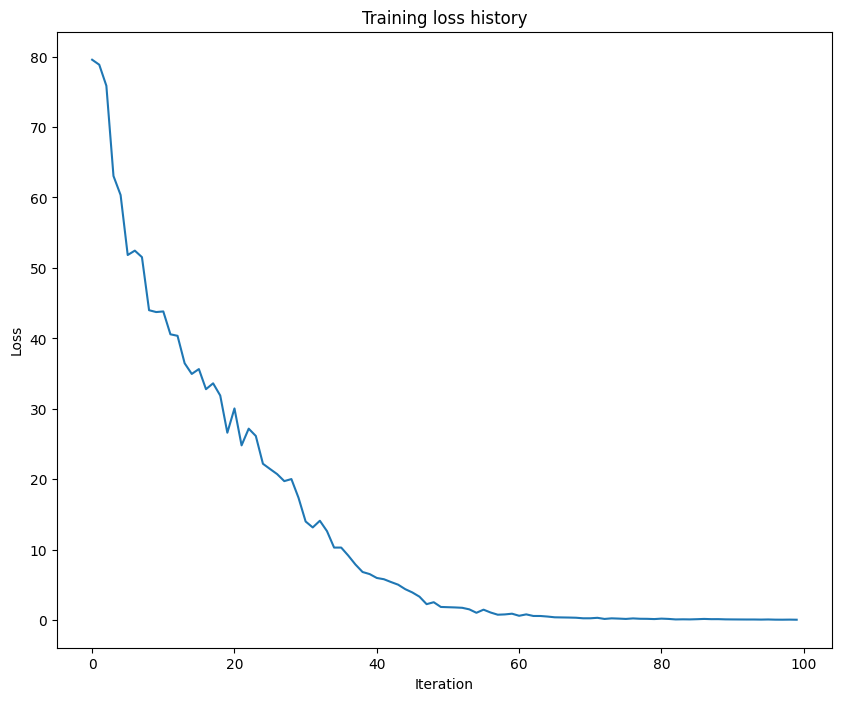

In [99]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
    cell_type='lstm',
    word_to_idx=small_data['word_to_idx'],
    input_dim=small_data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
    dtype=np.float32,
)

small_lstm_solver = CaptioningSolver(
    small_lstm_model, small_data,
    update_rule='adam',
    num_epochs=50,
    batch_size=25,
    optim_config={
     'learning_rate': 5e-3,
    },
    lr_decay=0.995,
    verbose=True, print_every=10,
)

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.5.

In [101]:
print('Final loss: ', small_lstm_solver.loss_history[-1])

Final loss:  0.08004410260627541


# LSTM Sampling at Test Time
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples. As with the RNN, training results should be very good, and validation results probably won't make a lot of sense (because we're overfitting).

In [ ]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img) 
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()